In [2]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

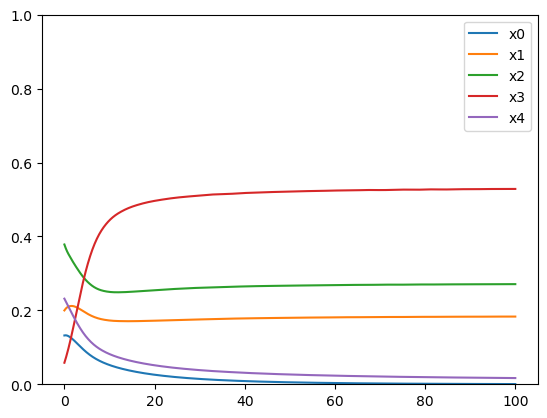

In [207]:
n = 5
alpha = np.random.rand(n)
alpha = alpha/np.sum(alpha)
beta = np.random.rand(n, n) * 0.1
K = 2/3

def f(t, x):
    res = np.zeros(n)
    for i in range(n):
        res[i] = x[i] * ((alpha[i] - x[i] / K) - np.sum(beta[:, i] * x) - beta[i, i] * x[i])

    return res 

x0 = np.random.rand(n)
x0 = x0 / np.sum(x0)
t = np.linspace(0, 100, 1000)

sol = solve_ivp(f, [0, 100], x0, t_eval=t)
sol.y = sol.y / np.sum(sol.y, axis=0)

for i in range(n):
    plt.plot(t, sol.y[i], label=f'x{i}')

plt.ylim(0, 1)
plt.legend()
plt.show()


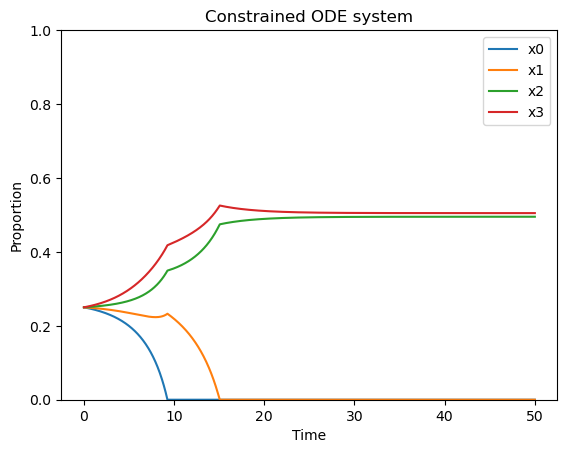

All 1 check: True


In [208]:
def original_ode(t, X, alpha, beta, K):
    """Define the unconstrained ODE system."""
    n = len(X)  # num companies
    dXdt = np.zeros(n)
    for i in range(n):
        competition = np.sum(beta[i, :] * X) - beta[i, i] * X[i]  # competition term, excluding self-competition
        growth = X[i] * alpha[i] * (1 - X[i] / K)  # logistic growth term
        dXdt[i] = growth - competition
    return dXdt

def project_to_simplex(X):
    """Project a vector onto the simplex sum(X) = 1, X >= 0.
    Follows algorithm 1. From https://stanford.edu/~jduchi/projects/DuchiShSiCh08.pdf
    """
    n = len(X)
    X_sorted = np.sort(X)[::-1]  # sort in descending order
    cumsum = np.cumsum(X_sorted)
    rho = np.where(X_sorted > (cumsum - 1) / np.arange(1, n + 1))[0][-1]  # find the largest index such that X_sorted > (cumsum - 1) / i
    theta = (cumsum[rho] - 1) / (rho + 1)  # (rho + 1) because rho is 0-indexed
    return np.maximum(X - theta, 0)

def solve(alpha, beta, K, X0, t):
    """Solve the constrained ODE system.
    The idea is that we solve the unconstrained ODE system, and then project the solution onto the simplex.
   So far uses a simple Forward Euler method.
   """
    n = len(X0)
    dt = t[1] - t[0]  # time step
    X = np.zeros((n, len(t)))  # store the solution here
    
    X0 = project_to_simplex(X0)  # project the initial condition onto the simplex if not already in it
    X[:, 0] = X0  # initial condition

    for i in range(1, len(t)):
        X[:, i] = X[:, i - 1] + dt * original_ode(t[i - 1], X[:, i - 1], alpha, beta, K)
        X[:, i] = project_to_simplex(X[:, i])
    
    return X

# Define the parameters
n = 4
alpha = np.array([0.66, 0.68, 0.7, 0.72])
beta = np.array([
    [0.0, 0.1, 0.1, 0.1],
    [0.1, 0.0, 0.1, 0.1],
    [0.1, 0.1, 0.0, 0.1],
    [0.1, 0.1, 0.1, 0.0]
])
K = 2/3
X0 = np.array([0.25, 0.25, 0.25, 0.25])
t = np.linspace(0, 50, 1000)

# Solve the system
X = solve(alpha, beta, K, X0, t)

for i in range(n):
    plt.plot(t, X[i, :], label=f'x{i}')

plt.ylim(0, 1)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Proportion')
plt.title('Constrained ODE system')
plt.show()

all_1_check = np.allclose(X.sum(axis=0), 1)
print(f'All 1 check: {all_1_check}')